# 建立换热器动态模型

In [1]:
import os,gzip,pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keys import Cols

# 设置字体为支持中文的字体，如SimHei（黑体）
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

## 读取原始运行数据

In [28]:
with gzip.open(
    r'D:\Devs\Single_Stack_MLJ\data\processed\Test data Hyzenis\2025.04.08-8.30-2025.04.11-17.30-10s-1# gzip',
    'rb'
) as f:
    df_Hyzenis = pickle.load(f)

In [29]:
df_Hyzenis = df_Hyzenis.rename(columns={'冷水调节阀1反馈': Cols.cooling_valve})

### 取适用于模型训练的部分数据

In [30]:
df_date_Hyzenis = df_Hyzenis.query(
    f"'2025-04-08 12:00:00'<{Cols.date_time}<'2025-04-11 14:00:00'"
)

### 原始数据展示

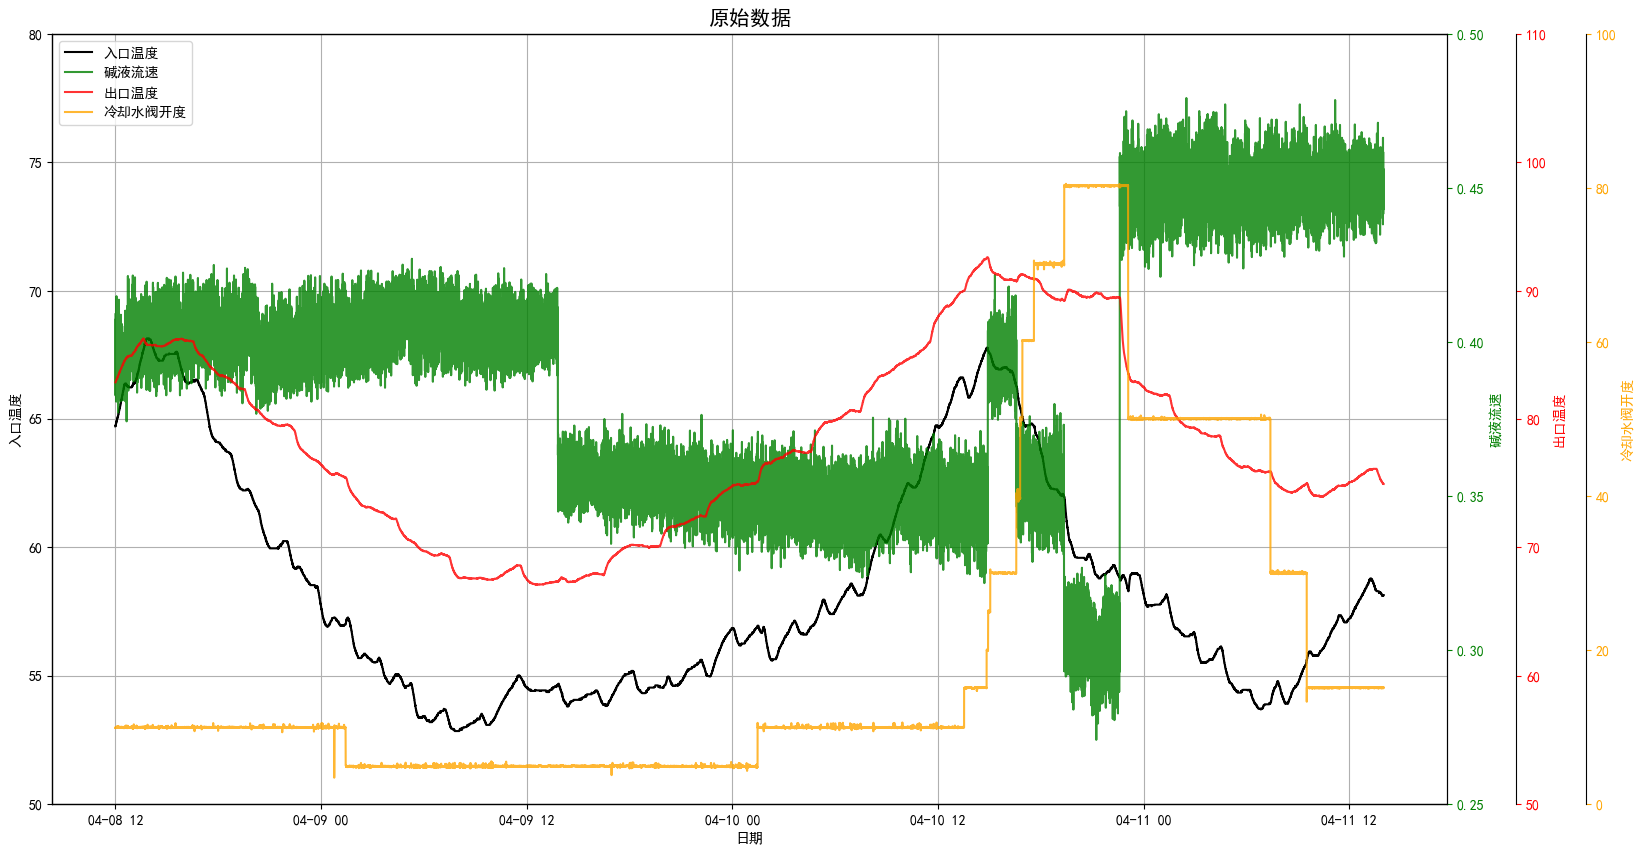

In [32]:
# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 替换为你系统中支持中文的字体路径，这里以黑体为例
prop = fm.FontProperties(fname=font_path)

# 创建图表和子图
fig, ax1 = plt.subplots(figsize=(18, 10))
plt.title('原始数据', fontproperties=prop, fontsize = 15)
plt.grid(True)

# 绘制第一个因变量的曲线
ax1.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.lye_temp], c = 'black', label = '入口温度')
ax1.set_xlabel('日期', fontproperties=prop)
ax1.set_ylabel('入口温度', color='black', fontproperties=prop)
ax1.set_ylim(50, 80)
ax1.tick_params('y', colors='black')

# 创建第二个y轴
ax2 = ax1.twinx()

# 绘制第二个因变量的曲线
ax2.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.lye_flow], alpha=0.8, c = 'green', label = '碱液流速')
ax2.set_ylabel('碱液流速', color='green', fontproperties=prop)
ax2.tick_params('y', colors='green')
ax2.set_ylim((0.25, 0.5))

# 创建第三个y轴
ax3 = ax1.twinx()

# 绘制第三个因变量的曲线
ax3.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.temp_out], c = 'red', alpha = 0.8,label = '出口温度')
ax3.set_ylabel('出口温度', color='red', fontproperties=prop)
ax3.spines['right'].set_position(('outward', 50))
ax3.tick_params('y', colors='red')
ax3.set_ylim(50, 110)

# 创建第三个y轴
ax4 = ax1.twinx()

# 绘制第二个因变量的曲线
ax4.plot(df_date_Hyzenis[Cols.date_time],df_date_Hyzenis[Cols.cooling_valve], c = 'orange', alpha = 0.8,label = '冷却水阀开度')
ax4.set_ylabel('冷却水阀开度', color='orange', fontproperties=prop)
ax4.spines['right'].set_position(('outward', 100))
ax4.tick_params('y', colors='orange')
ax4.set_ylim((0, 100))

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, loc='upper left', prop=prop)

# 显示图表
plt.show()

## 以LSTM为框架建立电解槽动态热模型

In [33]:
# 指定保存模型的文件夹路径
save_folder = 'Model\\Dynamic_models'

# 检查文件夹是否存在，如果不存在则创建
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# 构建保存模型的完整路径
save_path = os.path.join(save_folder, 'Thermodynamic_model_Exchanger.pth')

In [34]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [35]:
# 训练数据准备
feature_cols = [Cols.lye_flow, Cols.temp_environment, Cols.temp_out, Cols.cooling_valve]
target_cols = [Cols.lye_temp]

In [36]:
class HeatExchangerDataset(Dataset):
    def __init__(self, data, seq_length):
        self.seq_length = seq_length
        self.x_data = []
        self.y_data = []
        
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length, :-1]  # 输入特征: 入口温度、流量、阀门开度
            y = data[i+seq_length, -1]     # 目标: 出口温度
            self.x_data.append(x)
            self.y_data.append(y)
        
        self.x_data = torch.FloatTensor(np.array(self.x_data))
        self.y_data = torch.FloatTensor(np.array(self.y_data))
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))
        
        # 只取序列的最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

In [37]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=500):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            # 前向传播
            outputs = model(x)
            loss = criterion(outputs, y.unsqueeze(1))
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}')


def predict(model, test_loader, device):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            
            predictions.extend(outputs.cpu().numpy().flatten())
            actual.extend(y.cpu().numpy())
    
    return np.array(predictions), np.array(actual)

def evaluate_model(predictions, actual):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    print(f'评估指标:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [38]:
def plot_predictions(actual, predictions, title='碱液出口温度预测'):
    plt.figure(figsize=(14, 7))
    
    # 绘制完整预测对比图
    plt.subplot(2, 1, 1)
    plt.plot(actual, label='实际值', color='blue')
    plt.plot(predictions, label='预测值', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('时间步')
    plt.ylabel('温度 (°C)')
    plt.legend()
    plt.grid(True)
    
    # 绘制局部细节图
    plt.subplot(2, 1, 2)
    sample_range = slice(0, 200)  # 显示前200个点的细节
    plt.plot(actual[sample_range], label='实际值', color='blue')
    plt.plot(predictions[sample_range], label='预测值', color='red', alpha=0.7)
    plt.title('预测细节 (前200个时间步)')
    plt.xlabel('时间步')
    plt.ylabel('温度 (°C)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [39]:
def main():
    torch.manual_seed(42)
    np.random.seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 提取特征和目标数据
    data = df_date_Hyzenis[feature_cols + target_cols].copy()
    
    # 数据预处理
    # 标准化
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # 划分训练集和测试集
    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]
    
    # 创建数据集
    seq_length = 20  # 使用前20个时间步预测下一个
    train_dataset = HeatExchangerDataset(train_data, seq_length)
    test_dataset = HeatExchangerDataset(test_data, seq_length)
    
    # 创建数据加载器
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 模型参数
    input_size = len(feature_cols)  # 输入特征数量
    hidden_size = 64
    num_layers = 2
    output_size = len(target_cols)  # 输出特征数量
    
    # 初始化模型
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # 训练模型
    print("开始训练模型...")
    train_model(model, train_loader, criterion, optimizer, device, epochs=500)
    # 预测
    print("开始预测...")
    predictions, actual = predict(model, test_loader, device)
    
    # 反标准化
    # 创建目标变量的scaler
    target_scaler = MinMaxScaler()
    target_scaler.min_, target_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
    
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual = target_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()
    
    # 评估模型
    metrics = evaluate_model(predictions, actual)
    
    # 可视化
    plot_predictions(actual, predictions, title='碱液出口温度预测')

开始训练模型...
Epoch [10/500], Loss: 0.000436
Epoch [20/500], Loss: 0.000327
Epoch [30/500], Loss: 0.000280
Epoch [40/500], Loss: 0.000224
Epoch [50/500], Loss: 0.000149
Epoch [60/500], Loss: 0.000147
Epoch [70/500], Loss: 0.000130
Epoch [80/500], Loss: 0.000124
Epoch [90/500], Loss: 0.000114
Epoch [100/500], Loss: 0.000088
Epoch [110/500], Loss: 0.000078
Epoch [120/500], Loss: 0.000083
Epoch [130/500], Loss: 0.000061
Epoch [140/500], Loss: 0.000063
Epoch [150/500], Loss: 0.000061
Epoch [160/500], Loss: 0.000053
Epoch [170/500], Loss: 0.000047
Epoch [180/500], Loss: 0.000048
Epoch [190/500], Loss: 0.000051
Epoch [200/500], Loss: 0.000039
Epoch [210/500], Loss: 0.000045
Epoch [220/500], Loss: 0.000039
Epoch [230/500], Loss: 0.000039
Epoch [240/500], Loss: 0.000049
Epoch [250/500], Loss: 0.000041
Epoch [260/500], Loss: 0.000028
Epoch [270/500], Loss: 0.000037
Epoch [280/500], Loss: 0.000043
Epoch [290/500], Loss: 0.000032
Epoch [300/500], Loss: 0.000032
Epoch [310/500], Loss: 0.000028
Epoch [

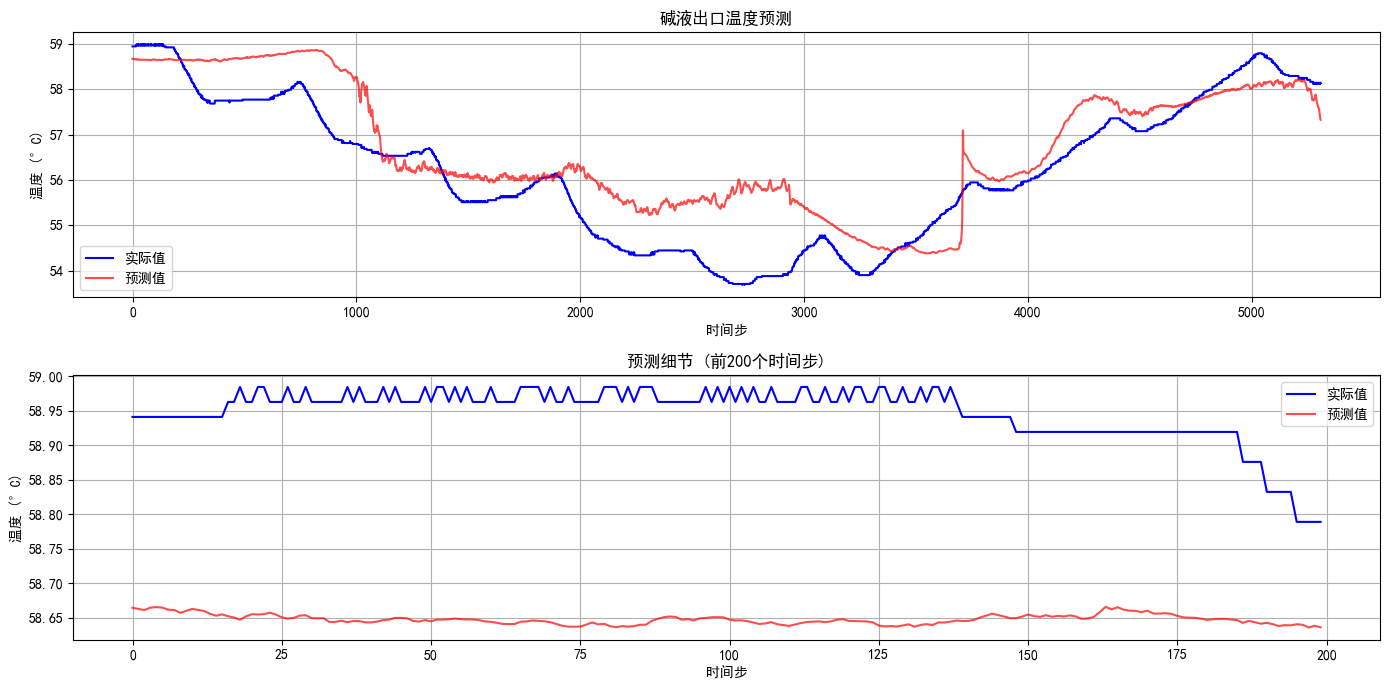

In [40]:
if __name__ == "__main__":
    main()    